In [4]:
from IPython.core.display import display, HTML
display(HTML('<h1 align="center">Should we backtest using overlapping windows?</h1><div style="text-align: right">Nikolai Nowaczyk 2023</div>'))

C:\Users\Thor\AppData\Local\Temp\ipykernel_19860\2429357839.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


Statistical backtests often rely on a sample comprised of a set of moving observation windows. When we allow the windows to overlap, we use all information in the data and have a high number of observations, yet, those observations are correlated. Leaving out all overlapping windows results in fewer, but independent observations. We study, which choice is ''better'' by calculating the statistical power of the various choices in some examples. The results show that overlapping windows result in a higher statistical power, but also require more computation to determine the rejection region.

In [2]:
%matplotlib notebook
import numpy as np
import scipy.stats as ss
import matplotlib.pyplot as plt
from statsmodels.distributions.empirical_distribution import ECDF
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import matplotlib.ticker as mtick
import ipywidgets as wdg

<IPython.core.display.Javascript object>


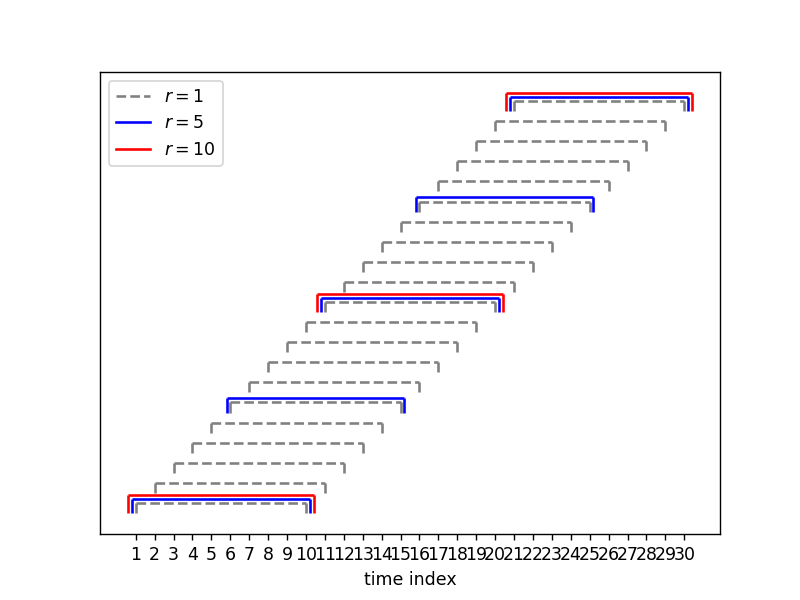

In [3]:
n = 30
m = 10
x = np.arange(0, n)
plt.figure("Overlapping Windows (of length m=10): Impact of step size r")
plt.xticks(x, x+1)
for i in range(0, n-m+1):
    plt.hlines(y=i, xmin=i, xmax=i+m-1, color='gray', linestyle='--')
    plt.vlines(i, ymin=i-.5, ymax=i, color='gray')
    plt.vlines(i+m-1, ymin=i-.5, ymax=i, color='gray')
for i in range(0, n-m+1, 5):
    d = 0.2
    plt.hlines(y=i+d, xmin=i-d, xmax=i+m-1+d, color='b')
    plt.vlines(i-d, ymin=i-.5, ymax=i+d, color='b')
    plt.vlines(i+m-1+d, ymin=i-.5, ymax=i+d, color='b')
for i in range(0, n-m+1, 10):
    d = 0.4
    plt.hlines(y=i+d, xmin=i-d, xmax=i+m-1+d, color='r')
    plt.vlines(i-d, ymin=i-.5, ymax=i+d, color='r')
    plt.vlines(i+m-1+d, ymin=i-.5, ymax=i+d, color='r')

handles, labels = plt.gca().get_legend_handles_labels()
handles.extend([Line2D([0], [0], label="$r=1$", color='gray', linestyle='--'),
                Line2D([0], [0], label="$r=5$", color='b'),
                Line2D([0], [0], label="$r=10$", color='r'),])
plt.legend(loc='upper left', handles=handles)
plt.yticks([])
plt.xlabel('time index')
plt.show()

# Problem Formalization
**Sample Space:** 
We start with the sample space
\begin{align*}
    (\mathbb{R}, \mathcal{B}_{\mathbb{R}}, \mathcal{N}(0, \sigma^2))^{\otimes n}, && \sigma \in \Theta := \mathbb{R}_{>0}
\end{align*}
i.e. our samples $Y=(Y_1, \ldots, Y_n)$ are given by $Y_i$, which are independent and identically distributed Gaussians with zero mean and a fixed variance $\sigma^2$, i.e.
\begin{align*}
Y_i \sim \mathcal{N}(0,\sigma^2), && i=1, \ldots, n.
\end{align*}
We think of $Y_i$ as independent time series returns over small increments (e.g. daily) with known mean of zero and unknown variance $\sigma^2$. For simplicity, we may write those as
\begin{align*}
    Y_i = \sigma Z_i, && Z_i \sim \mathcal{N}(0,1).
\end{align*}

Now, assume that we do not have direct access to those samples, but only to the $m$-day returns
\begin{align*}
    X_i := \sum_{j=i}^{i+m-1}{Y_{i}} \sim \mathcal{N}(0, m \sigma^2), && i=1, \ldots, n-m+1
\end{align*}
Those are also identically distributed, but no longer independent for $m>1$. By construction these correspond to an $m$-day window that moves by $r=1$ day. By ignoring some of those, we can also consider the samples resulting from a window that moves by a step size of $r$ days for $r \in \{1, \ldots, m\}$ resulting in the samples
\begin{align*}
    X_{r,j} := X_{rj}, && j=1, \ldots, n_r := \Big\lceil \frac{n - m + 1}{r} \Big \rceil
\end{align*}
living in the sample space
\begin{align*}
    (\mathbb{R}^{n_r}, \mathcal{B}_{\mathbb{R}}^{\otimes n_r}, \mathcal{N}(0, \Sigma_r(\sigma)), && \sigma \in \Theta := \mathbb{R}_{>0}.
\end{align*}
We study the resulting sample size $n_r$ and the correlation- respectively the covariance matrix $\Sigma_r(\sigma)$ below. 

**Null Hypothesis:** Two setups for the null hypothesis are meaningful: We can either study 
\begin{align*}
    H_0: \sigma \leq \sigma_0 && \text{against} && H_1: \sigma > \sigma_0 
\end{align*}
for some known variance $\sigma_0^2$, which corresponds to the decomposition $\Theta = \Theta_0 \cup \Theta_1$, $\Theta_0 := ]0, \sigma_0]$, $\Theta_1 := [\sigma_0, \infty[$ or, alternatively, 
\begin{align*}
    H_0: \sigma = \sigma_0 && \text{against} && H_1: \sigma \neq \sigma_0, 
\end{align*}
which corresponds to the decomposition $\Theta = \Theta_0 \cup \Theta_1$, $\Theta_0 := \{\sigma_0\}$, $\Theta_1 := \mathbb{R}_{>0} \setminus \{\sigma_0\}$.

## Correlation Structure
For any $i$, the samples $X_i$ and $X_{i+r}$, $1 \leq r \leq m-1$, have non-trivial correlation. More precisely, we have for any $1 \leq i \leq n$,
\begin{align*}
    \operatorname{Cov}[X_i, X_{i+r}]
    = \operatorname{Cov}\Big[\sum_{\nu=i}^{i+m-1}{Y_{\nu}}, \sum_{\mu=i+r}^{i+r+m-1}{Y_{\mu}} \Big]
    = \operatorname{Cov}\Big[\sum_{\nu=i+r}^{i+m-1}{Y_{\nu}}, \sum_{\mu=i+r}^{i+m-1}{Y_{\mu}} \Big]
    = \mathbb{V}\Big[\sum_{\nu=i+r}^{i+m-1}{Y_{\nu}}\Big]
    =(m-r)\sigma^2
\end{align*}
and hence
\begin{align*}
    \rho(X_i, X_{i+r})
    = \frac{\operatorname{Cov}[X_i, X_{i+r}]}{\sqrt{\mathbb{V}[X_i]}\sqrt{\mathbb{V}[X_{i+r}]}}
    = \frac{m-r}{m}
    = 1 - \frac{r}{m}.
\end{align*}

### Example

<IPython.core.display.Javascript object>


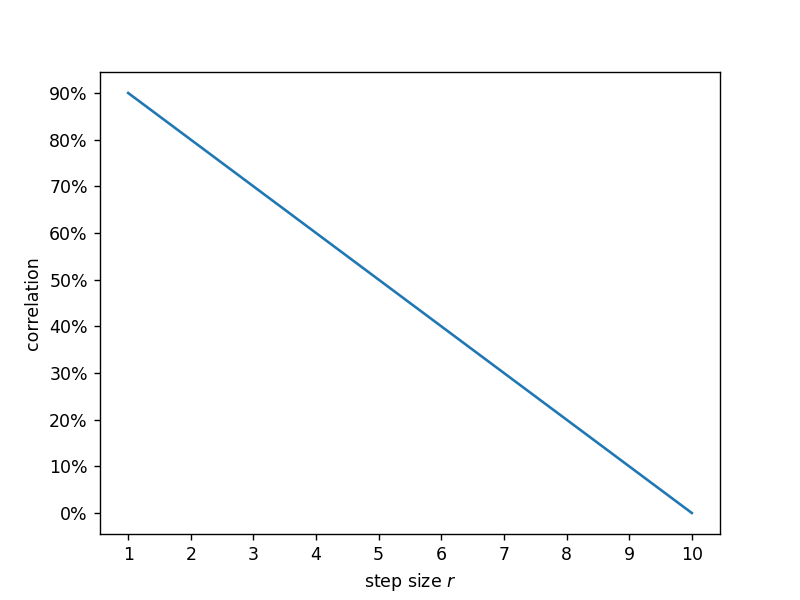

In [77]:
m = 10
r = np.arange(1, m+1)
rho = 1 - r / m
plt.figure("Correlation of Overlapping Samples (m=10)")
plt.plot(r,rho*100)
plt.xticks(r)
plt.xlabel('step size $r$')
plt.ylabel('correlation')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.yticks(np.arange(0, 100, 10))
plt.show()

We see that the correlation decays linearly with the step size in line with expectations.

## Sample Size
Starting from the sample $X_i$, $i=1, \ldots, n-m+1$, and the above insight, one might be tempted to throw away certain data points $X_i$ using the parameter $r$ in order to reduce the amount of correlation in the overall sample. For example, if we set $r=m$, then we again have independent samples, but a much lower number of them. Concretely, the number of samples left if every $r$-th sample is skipped is:
\begin{align*}
    n_r = \Big\lceil \frac{n - m + 1}{r} \Big \rceil
\end{align*}

### Example

<IPython.core.display.Javascript object>


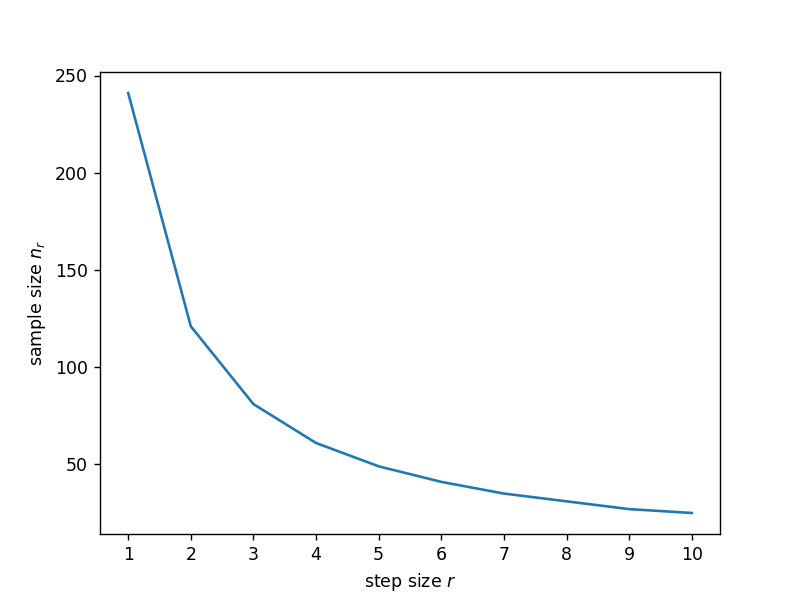

In [78]:
n = 250
m = 10
r = np.arange(1, m+1)
nr = np.ceil((n-m+1)/r)
plt.figure(f"Residual sample size of moving windows (n={n}, m={m})")
plt.plot(r,nr)
plt.xticks(r)
plt.xlabel('step size $r$')
plt.ylabel('sample size $n_r$')
plt.show()

We see that the sample size decays faster than linearly with the step size.

Atempting to combine the two measures, we calculate the *adjusted sample size* via
\begin{align*}
    \hat n_r := n_r (1-\rho)
\end{align*}

<IPython.core.display.Javascript object>


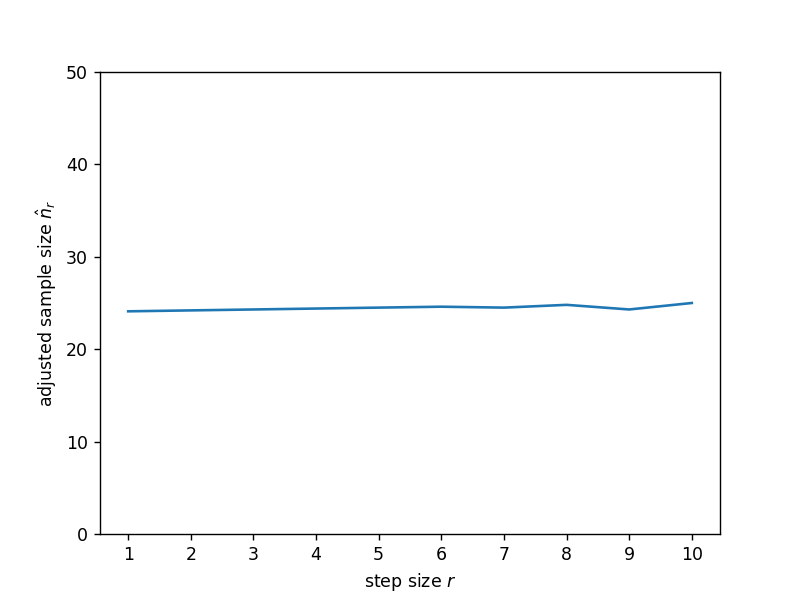

In [88]:
plt.figure(f"Adjusted Sample size (n={n}, m={m})")
plt.plot(r,nr * (1-rho))
plt.xticks(r)
plt.xlabel('step size $r$')
plt.ylabel('adjusted sample size $\hat{n}_r$')
plt.gca().set_ylim([0, 50])
plt.show()

We can see that the adjusted sample size stays roughly constant.

# Exceedance Count
**Test statistic:** Let $\gamma \in [0,1]$ be some quantile, e.g. $\gamma=0.99$, and 
\begin{align*}
    h := \sigma_0 \sqrt{m} \Phi^{-1}(\gamma)
\end{align*}
be the $\gamma$-quantile level of $X_i$ if $X_i$ were distributed as $\mathbb{P}_{\sigma_0} = \mathcal{N}(0, m\sigma_0^2)$. Then
\begin{align*}
    p_{\sigma} := \mathbb{P}_{\sigma}[X_i > h] = \mathbb{P}_{\sigma}[\sigma \sqrt{m} Z_i > \sigma_0 \sqrt{m}\Phi^{-1}(\gamma)] = 1 - \frac{\sigma_0}{\sigma}\gamma \in [0,1]
\end{align*}
can be thought of as the success probability of a Bernoulli experiment. However, the exceedence count
\begin{align*}
    S := \sum_{i=1}^{n}{1_{\{X_i > h \}}} 
\end{align*}
does not have Binomial distribution with success probability $p_{\sigma}$ for $m>1$ as the $X_i$ are not independent. We estimate this distriubtion via Monte Carlo.

**Rejection Region:** At significance level $\alpha$, e.g. $\alpha=0.05$, the rejection region is
\begin{align*}
   \{\varphi=1\} = \{S > \tilde{s}_{\operatorname{crit}} \},
\end{align*}
where $\tilde{s}_{\operatorname{crit}}$ is the $q$-quantile of the distribution of $S$ under $\mathbb{P}_{\sigma_0}$. 

**Power:** For any $\sigma_1 > \sigma_0$, we have
\begin{align*}
    G(\sigma_1) 
    = 1 - \beta(\sigma) 
    = 1 -  \mathbb{P}_{\sigma_1}[S \leq \tilde{s}_{\operatorname{crit}}]
\end{align*}

In [89]:
def independent_samples(sigma, n, nsims, seed=1):
    np.random.seed(seed)
    return ss.norm.rvs(loc=0, scale=sigma, size=(n, nsims))


def _create_windows(y, m, r):
    n = y.shape[0]
    return np.array([y[i:i + m, :] for i in range(0, n - m + 1, r)])


def overlap_samples(y, m, r=1):
    return np.sum(_create_windows(y, m, r), axis=1)


def threshold(sigma, q, m):
    return ss.norm.ppf(q, loc=0, scale=sigma) * np.sqrt(m)


def empirical_quantile(x, q):
    return ss.scoreatpercentile(x, q * 100, interpolation_method='lower')


def exceedance_count(sigma, n, nsims, seed, m, r, h):
    y = independent_samples(sigma, n, nsims, seed)
    x = overlap_samples(y, m, r)
    return np.sum(x > h, axis=0)

### Example Test

In [141]:
# configure test paramters
n = 250
m = 10
r = 1
sigma0 = 0.10
sigma = 0.09
gamma = 0.99
alpha = 0.05
nsims = 10000
seed = 3

# generate samples
h = threshold(sigma0, gamma, m)
s = exceedance_count(sigma, n, 1, seed, m, r, h).squeeze()

# evaluate test
s_crit = int(empirical_quantile(exceedance_count(sigma0, n, nsims, seed, m, r, h), 1-alpha))
print(f"Exceedances in sample: {s}")
print(f"Exceedances allowed: {s_crit}")
print(f"Null hypothesis rejected: {s > s_crit}")

Exceedances in sample: 3
Exceedances allowed: 9
Null hypothesis rejected: False


In [142]:
# power function
nsigma1 = 10
sigma1 = np.linspace(sigma0, 2*sigma0, nsigma1)
g1 = np.zeros_like(sigma1)

for i in range(sigma1.shape[0]):
    s = exceedance_count(sigma1[i], n, nsims, seed, m, r, h)
    g1[i] = 1-ECDF(s)(s_crit)

<IPython.core.display.Javascript object>


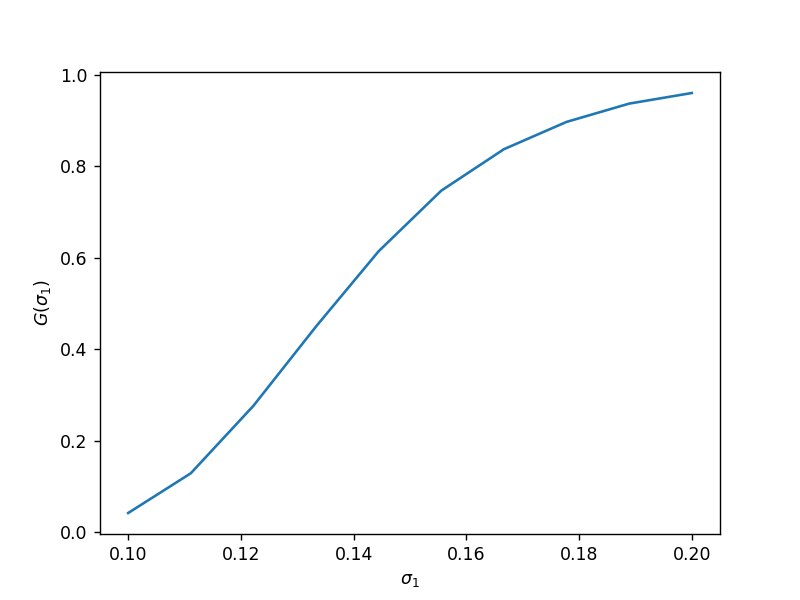

In [143]:
plt.figure("Power of fully correlated exceedance count")
plt.plot(sigma1, g1)
plt.xlabel("$\sigma_1$")
plt.ylabel("$G(\sigma_1)$")
plt.show()

### Impact of step size

In [145]:
s_dist = np.zeros((m, nsims))
s_crit = np.zeros(m)
for r in steps:
    s_dist[r-1, :] = exceedance_count(sigma0, n, nsims, seed, m, r, h)
    s_crit[r-1] = empirical_quantile(s_dist[r-1, :], 1 - alpha)

<IPython.core.display.Javascript object>


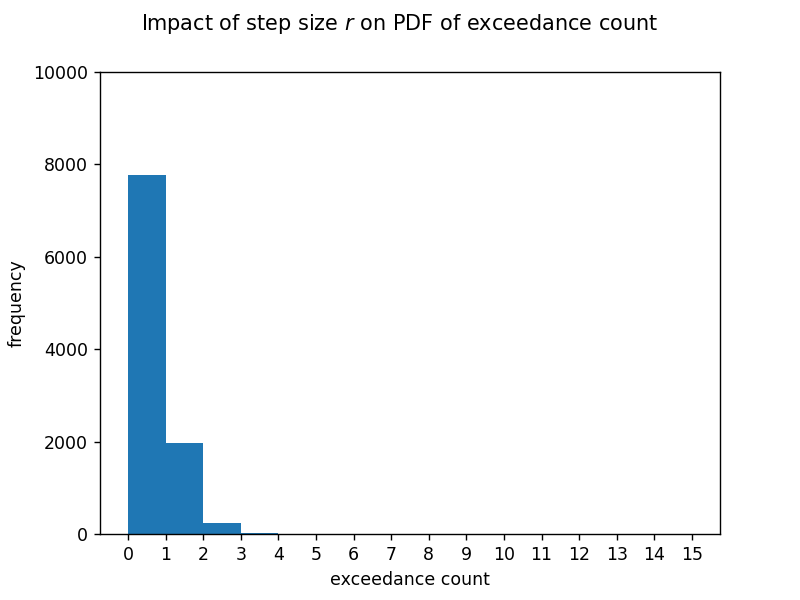

interactive(children=(IntSlider(value=10, description='r', max=10, min=1), Output()), _dom_classes=('widget-in…

In [146]:
figexcsd, axexcsd = plt.subplots()
figexcsd.suptitle("Impact of step size $r$ on PDF of exceedance count")
bins = np.linspace(0, 15, 16)

@wdg.interact(r=wdg.IntSlider(min=1, max=m, value=m))
def plot_exceedance_distribution(r):
    axexcsd.clear()
    axexcsd.hist(s_dist[r-1, :], bins=bins)
    axexcsd.set_ylim([0, 10000])
    axexcsd.set_xticks(bins)
    axexcsd.set_xlabel("exceedance count")
    axexcsd.set_ylabel("frequency")
    plt.show()

In [147]:
num_sigma1 = 10
sigma1 = np.linspace(sigma0, 3*sigma0, num_sigma1)
g1 = np.zeros((m, num_sigma1))

for r in steps:
    for i in range(sigma1.shape[0]):
        s = exceedance_count(sigma1[i], n, nsims, 10, m, r, h)
        g1[r-1, i] = 1-ECDF(s)(s_crit[r-1])

<IPython.core.display.Javascript object>


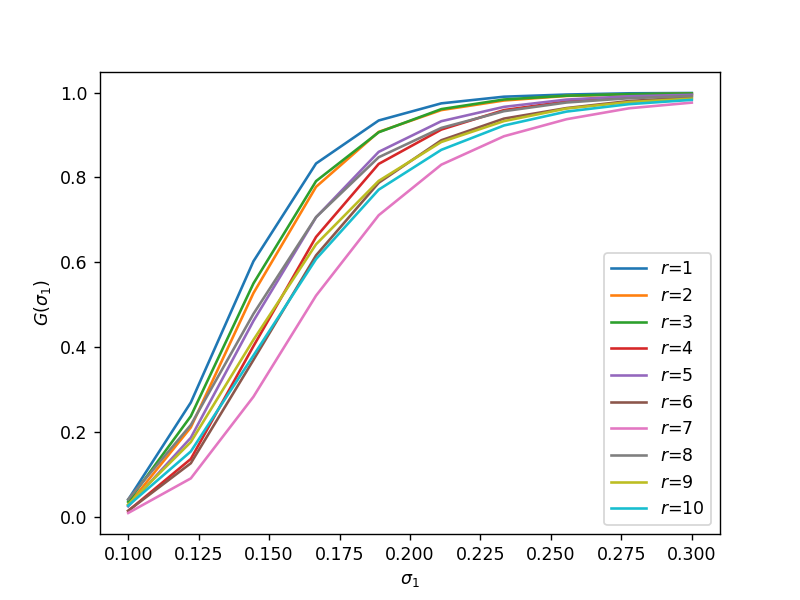

In [148]:
plt.figure("Impact of step size on power function of Exceedance Count")
plt.plot(sigma1, g1.T, label=[f"$r$={s}" for s in steps])
plt.xlabel("$\sigma_1$")
plt.ylabel("$G(\sigma_1)$")
plt.legend(loc='lower right')
plt.show()

We conclude that the test with step size $r=1$ is uniformly more powerful than all the others.

# Chi-Squared Test

**Test statistic:** Let $\gamma_1 < \ldots < \gamma_k$ be a grid of quantiles and 
\begin{align*}
    h_j := Q_{\sigma_0, \gamma_j}(X_i) = \sigma_0 \sqrt{m} \Phi^{-1}(\gamma_j)
\end{align*}
be the $\gamma_j$-quantile levels of $X_i$ if the $X_i$ were distributed according to $\mathbb{P}_{\sigma_0}$. 

We denote by
\begin{align*}
    e_j := n_r \mathbb{P}_{\sigma_0}[h_j \leq X_i < h_{j+1}] 
    = n_r (\gamma_{j+1} - \gamma_{j}), && 1 \leq j \leq k-1
\end{align*}
the *expected frequencies*. 

For a given sample $X_i$, $i=1, \ldots, n_r$, we denote by
\begin{align*}
    o_j := \# \{ X_i \mid h_j \leq X_i < h_{j+1} \}
\end{align*}
the *observed frequencies*. 

The test statistic is then given by
\begin{align*}
    \chi^2 := \sum_{j=1}^{k-1}{\frac{(o_j-e_j)^2}{e_j}}.
\end{align*}
We estimate this distriubtion via Monte Carlo.

**Rejection Region:** At significance level $\alpha$ level, e.g. $\alpha=0.05$, the rejection region is
\begin{align*}
    \{\varphi=1\} = \{ \chi^2 > \chi_{\operatorname{crit}}\},
\end{align*}
where $\chi_{\operatorname{crit}}$ is the $(1-\alpha)$-quantile of the distribution of $\chi^2$ under $\mathbb{P}_{\sigma_0}$. 

**Power:** For any $\sigma_1 \neq \sigma_0$, we have
\begin{align*}
    G(\sigma_1) 
    = 1 - \beta(\sigma) 
    = 1 -  \mathbb{P}_{\sigma_1}[\chi^2 \leq \chi_{\operatorname{crit}}]
\end{align*}

In [174]:
def observed_frequencies(x, h):
    o = np.zeros((h.shape[0]-1, x.shape[1]))
    nsims = x.shape[1]
    for w in range(nsims):
        o[:, w] = np.histogram(x[:, w], bins=h)[0]
    return o

def chi_squared_samples(sigma, n, m, nsims, gamma, h, r=1, seed=1):
    y = independent_samples(sigma, n, nsims, seed)
    x = overlap_samples(y, m, r)
    e = (gamma[1:] - gamma[:-1]) * x.shape[0]
    o = observed_frequencies(x, h)
    return np.sum((o - e[:, np.newaxis])**2/e[:, np.newaxis], axis=0)

### Test Example

In [175]:
# test parameters
n = 250
m = 10
r=1
sigma0 = 0.10
sigma = 0.09
gamma = np.array([0.05, 0.2, 0.5, 0.8, 0.95])
nsims = 10000
h = np.array([threshold(sigma0, q, m) for q in gamma])
alpha = 0.05
seed=1

In [176]:
# calculate critial threshold
chi_crit = empirical_quantile(chi_squared_samples(sigma0, n, m, nsims, gamma, h, r, seed), 1-alpha)

# generate samples
chis = chi_squared_samples(sigma, n, m, 1, gamma, h, r, seed=1).squeeze()

print(f"Chi^2 in sample: {chis}")
print(f"Chi^2 allowed: {chi_crit}")
print(f"Null hypothesis rejected: {chis > chi_crit}")

Chi^2 in sample: 25.81009681881052
Chi^2 allowed: 33.00511756569851
Null hypothesis rejected: False


### Impact of step size

In [177]:
steps = np.arange(1, m+1)
chis_crit = np.zeros(m)
chis_dist = np.zeros((m, nsims))
for r in steps:
    chis_dist[r-1, :] = chi_squared_samples(sigma0, n, m, nsims, gamma, h, r, seed=1)
    chis_crit[r-1] = empirical_quantile(chis_dist[r-1, :], 1-alpha)

<IPython.core.display.Javascript object>


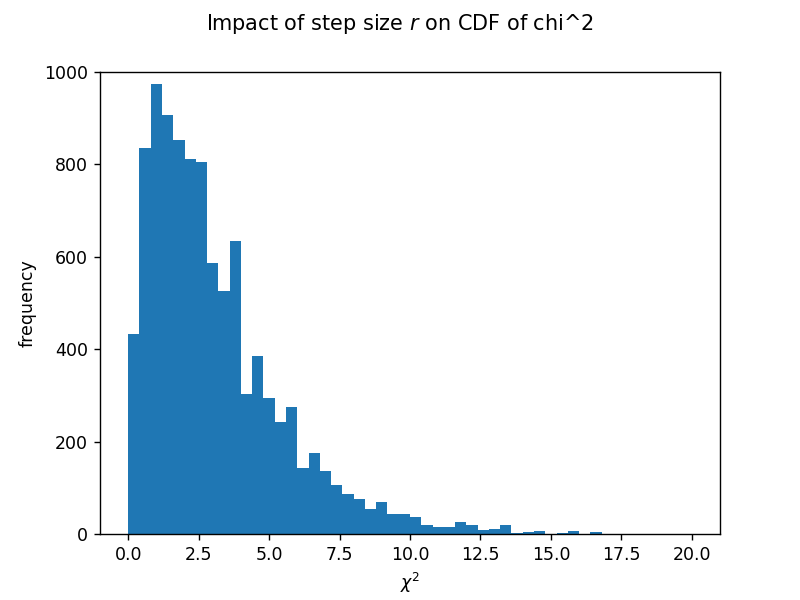

interactive(children=(IntSlider(value=10, description='r', max=10, min=1), Output()), _dom_classes=('widget-in…

In [182]:
figchisd, axchisd = plt.subplots()
figchisd.suptitle("Impact of step size $r$ on CDF of chi^2")
bins = np.linspace(0, 20, 51)

@wdg.interact(r=wdg.IntSlider(min=1, max=m, value=m))
def plot_chi_squared_distribution(r):
    axchisd.clear()
    axchisd.hist(chis_dist[r-1, :], bins=bins)
    axchisd.set_ylim([0, 1000])
    #axchisd.set_xticks(bins)
    axchisd.set_xlabel("$\chi^2$")
    axchisd.set_ylabel("frequency")
    plt.show()

In [183]:
num_sigma1 = 100
sigma1 = np.linspace(sigma0 - 0.05, sigma0 + 0.15, num_sigma1)
g1 = np.zeros((m, num_sigma1))

for r in steps:
    for i in range(sigma1.shape[0]):
        chis = chi_squared_samples(sigma1[i], n, m, nsims, gamma, h, r, seed=1)
        g1[r-1, i] = 1-ECDF(chis)(chis_crit[r-1])

<IPython.core.display.Javascript object>


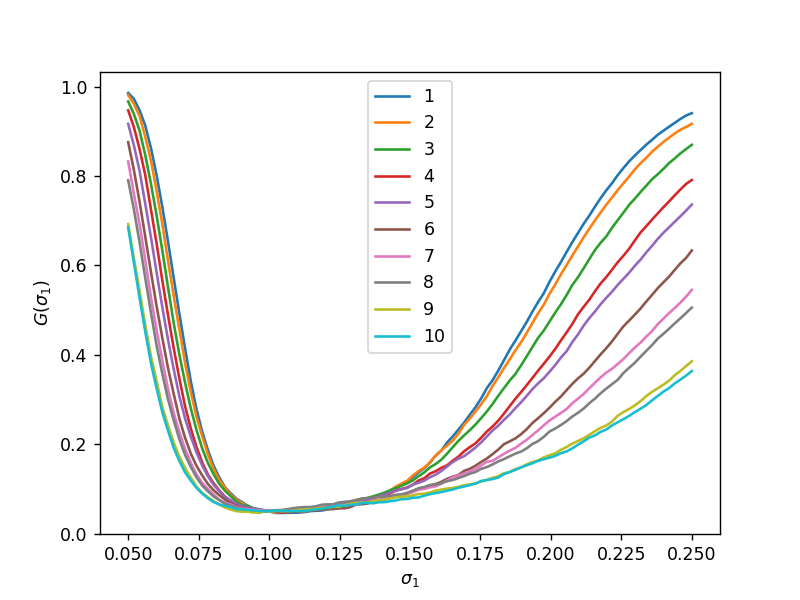

In [185]:
plt.figure("Impact of step size on power function of chi-squared test")
plt.plot(sigma1, g1.T, label=steps)
plt.xlabel("$\sigma_1$")
plt.ylabel("$G(\sigma_1)$")
plt.legend()
plt.show()

# Appendix: Statistical Hypothesis Testing

**Definition (statistical model):** A tiplet $\mathfrak{X} = (\mathfrak{X}, \mathcal{F}, \mathbb{P}_{\vartheta})_{\theta \in \Theta}$ is called a *statistical model*, if $\Theta$ is an arbitrary set (of at least two elements) and for any $\vartheta \in \Theta$, $ (\mathfrak{X}, \mathcal{F}, \mathbb{P}_{\vartheta})$ is a probability space. We sometimes say $\mathfrak{X}$ is the *sample space*. 


**Definition (hypothesis test):** Let $\mathfrak{X} = (\mathfrak{X}, \mathcal{F}, \mathbb{P}_{\vartheta})_{\theta \in \Theta}$ be a statistical model and let $\Theta = \Theta_0 \dot{\cup} \Theta_1$ be a disjoint union with $\Theta_0 \neq \emptyset$. 
* We call $\Theta_0$ *null hypothesis* and $\Theta_1$ is called *alternative*.
* Any statistic $\varphi:(\mathfrak{X}, \mathcal{F}) \to \{0, 1\}$ is called *decision rule*. 
* The regions $\{\varphi(x) = 0\}$ respectively  $\{\varphi(x) = 1\}$ are called the *retention region*, respectively, *rejection region*.
* The map 
    \begin{align*}
        G_{\varphi}:\Theta \to [0,1], && \vartheta \mapsto \mathbb{P}_{\vartheta}[\{\varphi=1\}]
    \end{align*}
    is called *power function* of $\varphi$.
* A number $0 \leq \alpha \leq 1$ (typically: $\alpha=5\%$) is called *signifigance level* of $\varphi$ if 
\begin{align*}
    l_{\varphi} := \sup_{\vartheta \in \Theta_0}{G_{\varphi}(\vartheta)} \leq \alpha.
\end{align*}

**Error types:** For any hypothesis test $\varphi$ and any given sample $x \in \mathfrak{X}$, we can make two types of errors:
* *Type I error:* We reject the null hypothesis even though it is correct. This means that the true probability measure is given by some $\vartheta_0 \in \Theta_0$, but $\varphi(x)=1$. By construction, this happens with probability 
\begin{align*}
    \mathbb{P}_{\vartheta_0}[\{\varphi=1\}] \leq l_{\varphi} \leq \alpha.
\end{align*}
* *Type II error:* We retain the null hpyothesis, but we should have rejected it. This means that the true probability measure is given by some $\vartheta_1 \in \Theta_1$, but $\varphi(x)=0$. The probability of this, is related to statistical power via the function
\begin{align*}
    \beta_{\varphi}: \Theta_1 \to [0,1], && \vartheta_1 \mapsto 1 - G_{\varphi}(\theta_1).
\end{align*}

**Uniformly most powerful (UMP):** A test $\varphi$ is *uniformly most powerful (UMP) at significance $\alpha$* , if
1. $\varphi$ is of significance $\alpha$, i.e.
\begin{align*}
    \sup_{\vartheta \in \Theta_0}{G_{\varphi}(\vartheta)} \leq \alpha
\end{align*}
2. For any other test $\psi$ of significance $\alpha$
\begin{align*}
    \forall \vartheta_1 \in \Theta_1: G_{\varphi}(\vartheta_1) \geq G_{\psi}(\vartheta_1).
\end{align*}

This means that we optimize tests of significance $\alpha$, i.e. tests that have a low type I error to begin with, by maximizing their power, hence minimizing their type II error as well.

## Example: Exceedance Counting - Independent Case

**Test statistic:** Let $\gamma \in [0,1]$ be some quantile, e.g. $\gamma=0.99$, and 
\begin{align*}
    h := \sigma_0 \Phi^{-1}(\gamma)
\end{align*}
be the $\gamma$-quantile level of $Y_i$, if $Y_i$ were distributed as $\mathcal{N}(0, \sigma_0^2)$. This is the threshold with respect to which we are calculating the exceedances. Hence,
\begin{align*}
    p_{\sigma} := \mathbb{P}_{\sigma}[Y_i > h] = \mathbb{P}_{\sigma}[\sigma Z_i > \sigma_0 \Phi^{-1}(\gamma)] = 1 - \frac{\sigma_0}{\sigma}\gamma \in [0,1]
\end{align*}
can be thought of as the success probability of a Bernoulli experiment and hence the exceedence count
\begin{align*}
    S := \sum_{i=1}^{n}{1_{\{Y_i > h \}}} 
\end{align*}
has Binomial distribution with success probability $p_{\sigma}$, i.e. $S \sim \operatorname{Ber}_{p_\sigma}(n)$.

**Rejection Region:** At $\alpha$ level, e.g. $\alpha=0.05$, the rejection region of this test $\varphi$ is
\begin{align*}
    \{\varphi=1\} = \{S > s_{\operatorname{crit}}\},
\end{align*}
where $s_{\operatorname{crit}}$ is the $1-\gamma$-quantile of $\operatorname{Ber}_{p_{\sigma_0}}(n)$. Notice that $p_{\sigma}$ is decreasing in $\sigma$, hence $\sigma=\sigma_0$ is the critical probability distribution under which we calculate the rejection region.

**Power:** For any $\sigma_1 > \sigma_0$, we have
\begin{align*}
    G(\sigma_1) 
    = 1 - \beta(\sigma_1) 
    = 1 -  \mathbb{P}_{\sigma_1}[S \leq s_{\operatorname{crit}}]
    = 1 - \sum_{k=0}^{s_{\operatorname{crit}}}{\binom{n}{k}p_{\sigma_1}^k (1-p_{\sigma_1})^{n-k}}
\end{align*}

### Example Test

<IPython.core.display.Javascript object>


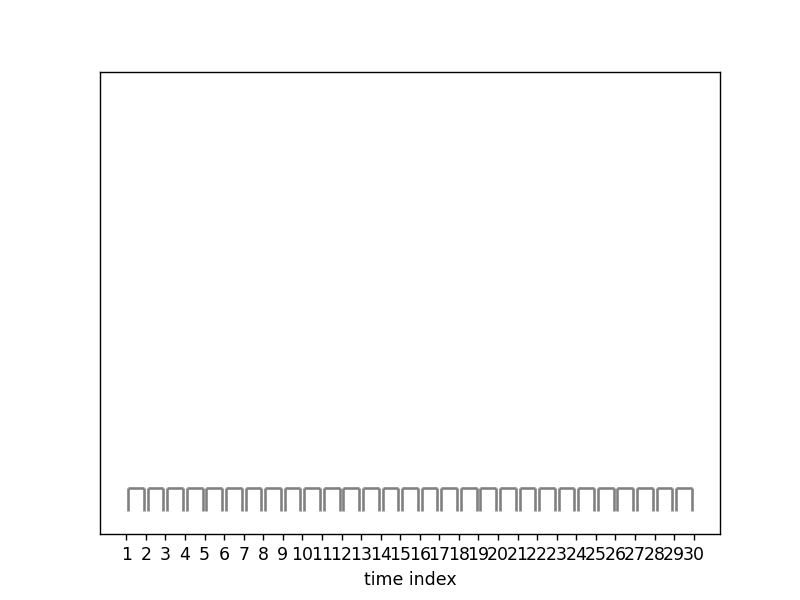

In [44]:
n = 30
x = np.arange(0, n)
plt.figure("Non-Overlapping Window: Daily returns")
plt.xticks(x, x+1)
b = 0.1
for i in range(0, n-1):
    plt.hlines(y=1, xmin=i+b, xmax=i+1-b, color='gray')
    plt.vlines(i+b, ymin=.5, ymax=1, color='gray')
    plt.vlines(i+1-b, ymin=.5, ymax=1, color='gray')
plt.xlabel('time index')
plt.gca().set_ylim([0, 10])
plt.yticks([])
plt.show()

In [45]:
# configure test paramters
n = 250
sigma0 = 0.10
sigma = 0.09
gamma = 0.99
alpha = 0.05

# generate samples
np.random.seed(3)
y = ss.norm.rvs(loc=0, scale=sigma, size=n)
h = ss.norm.ppf(gamma, 0, sigma0)
s = np.sum(y>h)

# evaluate test
p0 = 1 - ss.norm.cdf(h, loc=0, scale=sigma0)
s_crit = ss.binom.ppf(1-alpha, n, p0)
print(f"Exceedances in sample: {s}")
print(f"Exceedances allowed: {s_crit}")
print(f"Null hypothesis rejected: {s > s_crit}")

Exceedances in sample: 2
Exceedances allowed: 5.0
Null hypothesis rejected: False


<IPython.core.display.Javascript object>


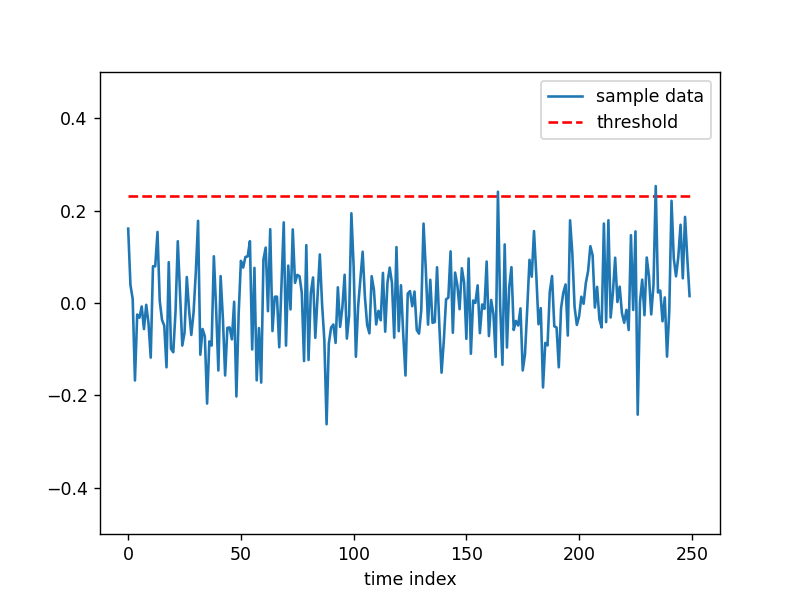

In [46]:
plt.figure("Example of a sample y (n=250) and the threshold h")
plt.plot(np.arange(n), y, label='sample data')
plt.hlines(h, xmin=0, xmax=n, color='r', linestyle='--', label="threshold")
plt.xlabel("time index")
plt.gca().set_ylim([-0.5, 0.5])
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


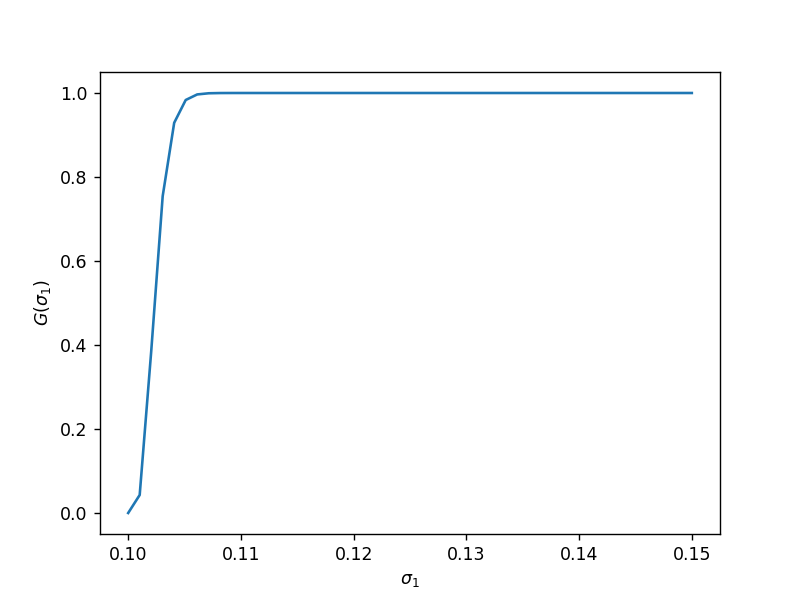

In [47]:
# power function
sigma1 = np.linspace(sigma0, sigma0+0.05, 50)
g1 = 1 -ss.binom.cdf(s_crit, n, 1 - sigma0/sigma1)

plt.figure("Power function of exceedance count (independent case)")
plt.plot(sigma1, g1)
plt.xlabel("$\sigma_1$")
plt.ylabel("$G(\sigma_1)$")
plt.show()

<IPython.core.display.Javascript object>


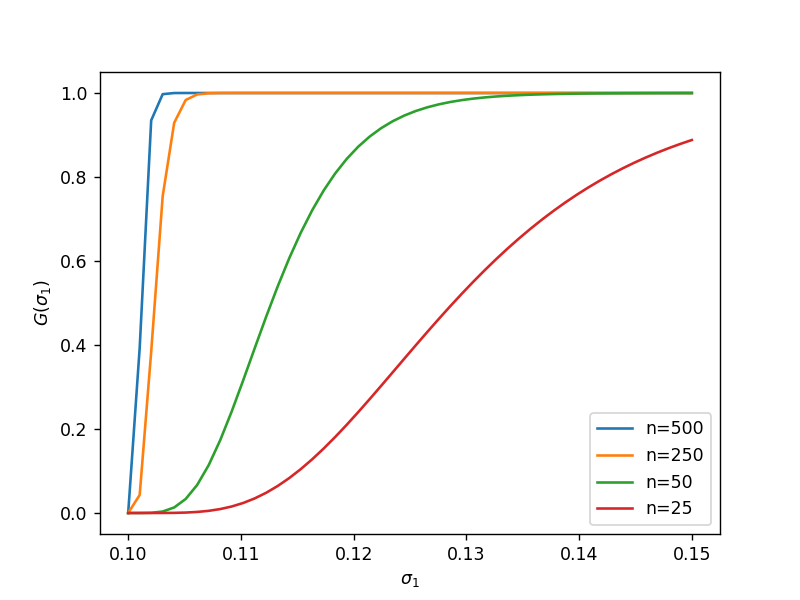

In [48]:
plt.figure("Impact of sample size on power")
for nalt in [2*n, n, n/5, n/10]:
    plt.plot(sigma1, 1 -ss.binom.cdf(s_crit, nalt, 1 - sigma0/sigma1), label=f"n={int(nalt)}")
plt.legend()
plt.xlabel("$\sigma_1$")
plt.ylabel("$G(\sigma_1)$")
plt.show()